<a href="https://colab.research.google.com/github/DoggoSantini/coding/blob/main/u_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load data through Kaggle

In [1]:
! pip install kaggle
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle_api_cred/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
! kaggle datasets download mateuszbuda/lgg-mri-segmentation

lgg-mri-segmentation.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
! unzip /content/lgg-mri-segmentation.zip

Archive:  /content/lgg-mri-segmentation.zip
replace kaggle_3m/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Imports and version checks

In [4]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Tensorflow version", tf.__version__)

Tensorflow version 2.12.0


In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


Loading data into tensors

In [6]:
data_x = np.empty(shape=(3930, 256, 256, 3)) # 3930 samples of 256x256x3 images (non_masks)
data_y = np.empty(shape=(3930, 256, 256)) # 3930 samples of 256x256 images (masks)

counter = 0

data_path = '/content/kaggle_3m'

folders = os.listdir(data_path)
folders = [folder for folder in folders if '.' not in folder] # remove README.md and data.csv

for folder in folders:
  folder_path = os.path.join(data_path, folder)

  files = os.listdir(folder_path)
  files = [file for file in files if 'mask' not in file] # remove masks from iteration so we can load them alongside the base image

  for file in files:
    file_path = os.path.join(folder_path, file)
    temp_x = mpimg.imread(file_path)
    data_x[counter, :, :, :] = temp_x

    temp_y = mpimg.imread(file_path.replace('.tif', '_mask.tif'))
    data_y[counter, :, :] = temp_y
    
    counter += 1

data_x = np.divide(data_x, 255, dtype=np.float16)
data_y = np.divide(data_y, 255, dtype=np.float16)

Viewing data

In [7]:
data_x = tf.convert_to_tensor(data_x, dtype = tf.float16)

In [8]:
data_y = tf.convert_to_tensor(data_y, dtype = tf.float16)

In [9]:
data_y = tf.expand_dims(data_y, axis=-1)

In [10]:
data_x.shape, data_y.shape

(TensorShape([3930, 256, 256, 3]), TensorShape([3930, 256, 256, 1]))

In [11]:
idxs = tf.range(tf.shape(data_x)[0])
idxs = tf.random.shuffle(idxs)[:3]
idxs = tf.sort(idxs)

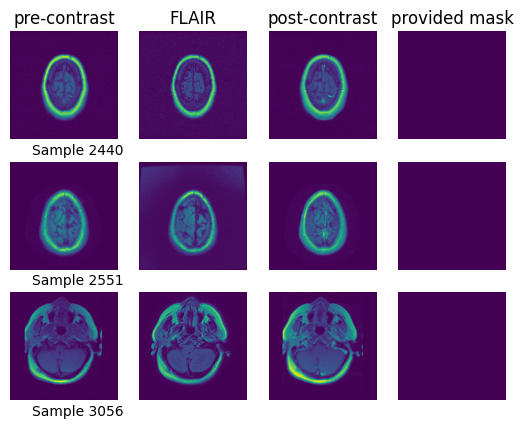

In [12]:
fig, axs = plt.subplots(3, 4)

# Titles for MRI type
axs[0][0].title.set_text('pre-contrast')
axs[0][1].title.set_text('FLAIR')
axs[0][2].title.set_text('post-contrast')
axs[0][3].title.set_text('provided mask')

for i in range(3):
  # Sample no.
  axs[i][0].text(0.2, -0.1, f'Sample {idxs[i]}', verticalalignment='center', transform=axs[i][0].transAxes)

  axs[i][0].imshow(data_x[idxs[i], :, :, 0])
  axs[i][0].axis('off')

  axs[i][1].imshow(data_x[idxs[i], :, :, 1])
  axs[i][1].axis('off')

  axs[i][2].imshow(data_x[idxs[i], :, :, 2])
  axs[i][2].axis('off')

  axs[i][3].imshow(data_y[idxs[i], :, :, 0])
  axs[i][3].axis('off')
  
plt.show()

Training-Validation-Testing Split (70:15:15)

In [38]:
no_samples = data_x.shape[0]
idxs = tf.random.shuffle(range(no_samples), seed=0)

# get indices for sampling
train_idxs = idxs[:int(no_samples * .70)]
val_idxs = idxs[int(no_samples * .70):int(no_samples * .85)]
test_idxs = idxs[int(no_samples * .85):]

train_x = tf.gather(data_x, train_idxs)
val_x = tf.gather(data_x, val_idxs)
test_x = tf.gather(data_x, test_idxs)

train_y = tf.gather(data_y, train_idxs)
val_y = tf.gather(data_y, val_idxs)
test_y = tf.gather(data_y, test_idxs)

In [39]:
train_x.shape, val_x.shape, test_x.shape # sense check

(TensorShape([2751, 256, 256, 3]),
 TensorShape([589, 256, 256, 3]),
 TensorShape([590, 256, 256, 3]))

In [41]:
train_y.shape, val_y.shape, test_y.shape

(TensorShape([2751, 256, 256, 1]),
 TensorShape([589, 256, 256, 1]),
 TensorShape([590, 256, 256, 1]))

Creating UNet Model

In [42]:
class UNet(tf.keras.Model):
  def __init__(self):
    super().__init__()

    # Encoder
    self.input_layer = tf.keras.layers.Input(shape=(256, 256, ))

    self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.pool1 = tf.keras.layers.MaxPooling2D(2)
    self.dropout1 = tf.keras.layers.Dropout(0.5)

    self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.pool2 = tf.keras.layers.MaxPooling2D(2)
    self.dropout2 = tf.keras.layers.Dropout(0.5)

    self.conv5 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
    self.conv6 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
    self.pool3 = tf.keras.layers.MaxPooling2D(2)
    self.dropout3 = tf.keras.layers.Dropout(0.5)

    self.conv7 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')
    self.conv8 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')
    self.pool4 = tf.keras.layers.MaxPooling2D(2)
    self.dropout4 = tf.keras.layers.Dropout(0.5)

    # Bottleneck
    self.conv9 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')
    self.conv10 = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu')
    self.dropout5 = tf.keras.layers.Dropout(0.5)

    # Decoder
    self.upconv1 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2, strides=2, padding='valid', activation='relu')
    self.conv11 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')
    self.conv12 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')
    self.dropout6 = tf.keras.layers.Dropout(0.5)
    
    self.upconv2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding='valid', activation='relu')
    self.conv13 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
    self.conv14 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')
    self.dropout7 = tf.keras.layers.Dropout(0.5)
    
    self.upconv3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu')
    self.conv15 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.conv16 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')
    self.dropout8 = tf.keras.layers.Dropout(0.5)
    
    self.upconv4 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='valid', activation='relu')
    self.conv17 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.conv18 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
    self.dropout9 = tf.keras.layers.Dropout(0.5)

    self.conv19 = tf.keras.layers.Conv2D(filters=1, kernel_size=1, padding='same', activation='sigmoid')

    self.concat = tf.keras.layers.Concatenate()

  def call(self, inputs, training=False):
    
    # Encoder
    x = self.conv1(inputs)
    x = self.conv2(x)
    copy_1 = x
    x = self.pool1(x)
    if training: x = self.dropout1(x)

    x = self.conv3(x)
    x = self.conv4(x)
    copy_2 = x
    x = self.pool2(x)
    if training: x = self.dropout2(x)

    x = self.conv5(x)
    x = self.conv6(x)
    copy_3 = x
    x = self.pool3(x)
    if training: x = self.dropout3(x)

    x = self.conv7(x)
    x = self.conv8(x)
    copy_4 = x
    x = self.pool4(x)
    if training: x = self.dropout4(x)
    
    # Bottleneck
    x = self.conv9(x)
    x = self.conv10(x)
    if training: x = self.dropout5(x)

    # Decoder
    x = self.upconv1(x)
    x = self.concat([x, copy_4])
    x = self.conv11(x)
    x = self.conv12(x)
    if training: x = self.dropout6(x)
    
    x = self.upconv2(x)
    x = self.concat([x, copy_3])
    x = self.conv13(x)
    x = self.conv14(x)
    if training: x = self.dropout6(x)

    x = self.upconv3(x)
    x = self.concat([x, copy_2])
    x = self.conv15(x)
    x = self.conv16(x)
    if training: x = self.dropout6(x)

    x = self.upconv4(x)
    x = self.concat([x, copy_1])
    x = self.conv17(x)
    x = self.conv18(x)

    x = self.conv19(x)

    return x

In [43]:
unet = UNet()

In [47]:
unet.compile(optimizer='Adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [48]:
unet.build(input_shape=(None, 256, 256, 3));

In [49]:
unet.summary()

Model: "u_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 conv2d_1 (Conv2D)           multiple                  9248      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 dropout (Dropout)           multiple                  0 (unused)
                                                                 
 conv2d_2 (Conv2D)           multiple                  18496     
                                                                 
 conv2d_3 (Conv2D)           multiple                  36928     
                                                             

In [50]:
hist = unet.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=30, epochs=10)

Epoch 1/10
92/92 [==============================] - 111s 866ms/step - loss: 0.1331 - accuracy: 0.9851 - val_loss: 0.0341 - val_accuracy: 0.9893
Epoch 2/10
92/92 [==============================] - 64s 701ms/step - loss: 0.0303 - accuracy: 0.9895 - val_loss: 0.0312 - val_accuracy: 0.9893
Epoch 3/10
92/92 [==============================] - 67s 727ms/step - loss: 0.0285 - accuracy: 0.9906 - val_loss: 0.0287 - val_accuracy: 0.9916
Epoch 4/10
92/92 [==============================] - 67s 726ms/step - loss: 0.0254 - accuracy: 0.9925 - val_loss: 0.0279 - val_accuracy: 0.9913
Epoch 5/10
92/92 [==============================] - 67s 724ms/step - loss: 0.0247 - accuracy: 0.9926 - val_loss: 0.0267 - val_accuracy: 0.9919
Epoch 6/10
92/92 [==============================] - 67s 723ms/step - loss: 0.0237 - accuracy: 0.9928 - val_loss: 0.0254 - val_accuracy: 0.9921
Epoch 7/10
92/92 [==============================] - 64s 698ms/step - loss: 0.0231 - accuracy: 0.9929 - val_loss: 0.0243 - val_accuracy: 0.992

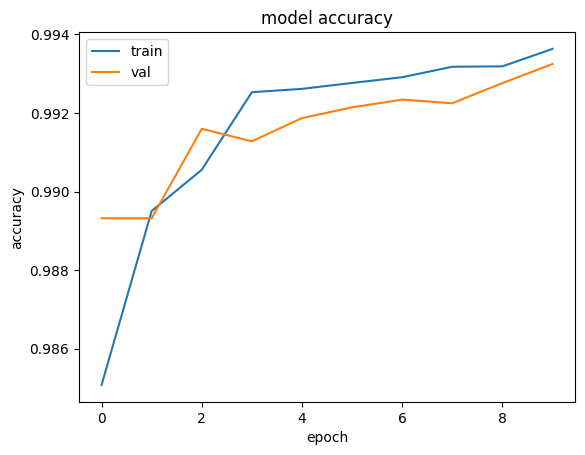

In [51]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

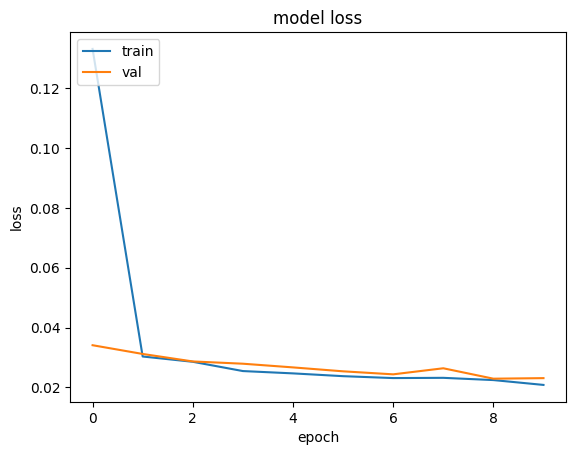

In [54]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Testing Performance

In [56]:
test_loss, test_accuracy = unet.evaluate(test_x, test_y)

19/19 [==============================] - 3s 147ms/step - loss: 0.0215 - accuracy: 0.9938


In [59]:
print(f'Test Loss:\t{test_loss:.3f}\nTest Accuracy:\t{test_accuracy*100:.2f}%')

Test Loss:	0.022
Test Accuracy:	99.38%


Viewing Results

In [60]:
test_pred = unet.predict(test_x)

19/19 [==============================] - 3s 150ms/step


In [75]:
idxs = tf.range(tf.shape(test_x)[0])
idxs = tf.random.shuffle(idxs)[:10]
idxs = tf.sort(idxs)

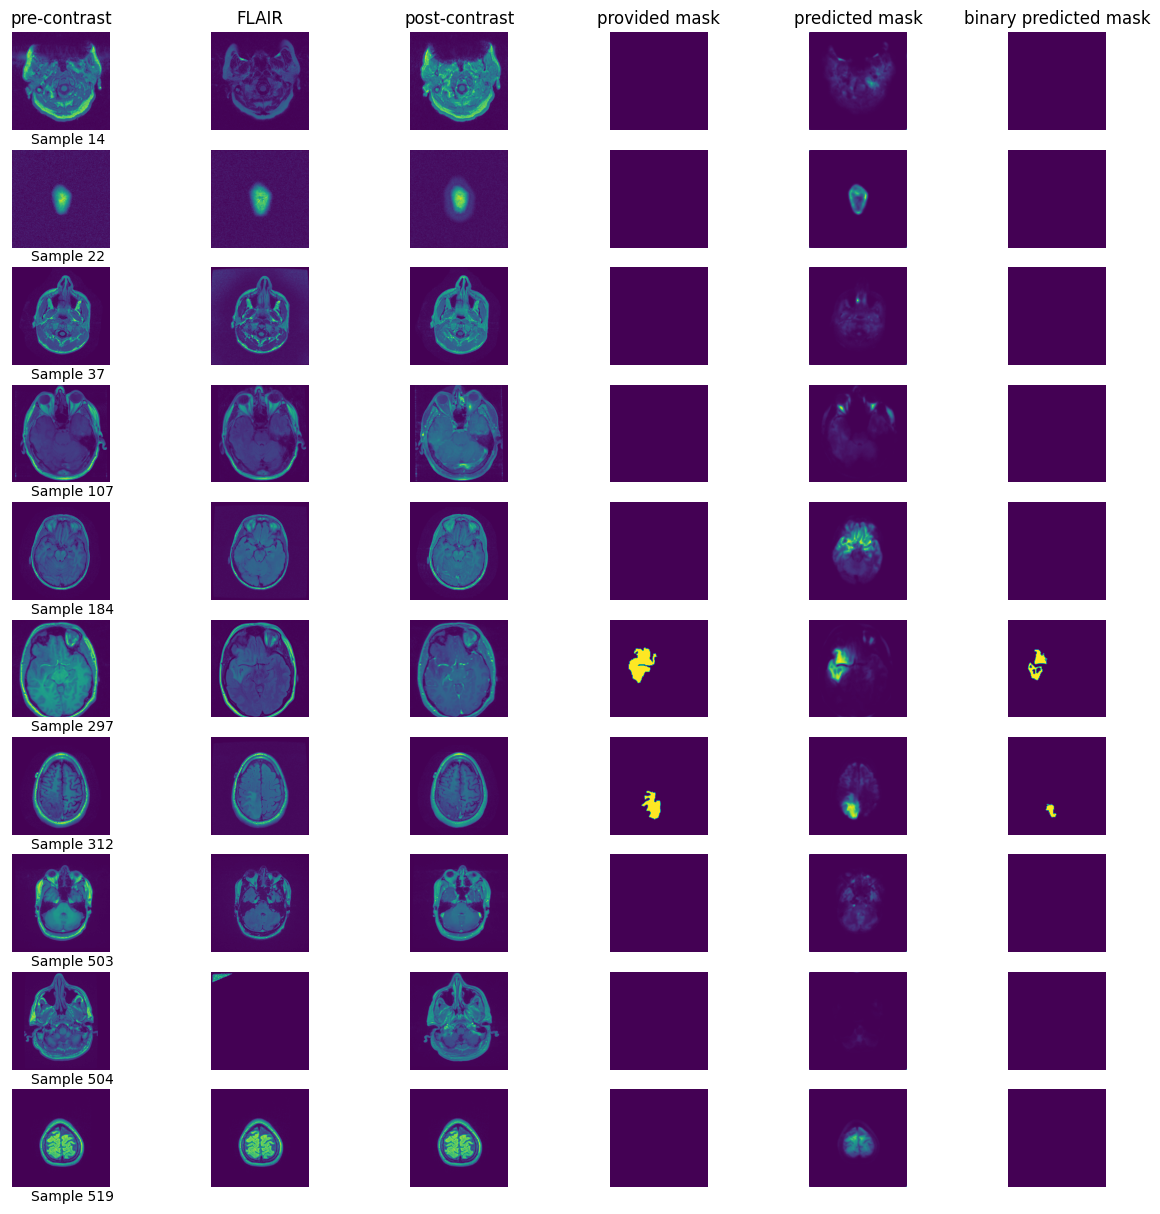

In [79]:
fig, axs = plt.subplots(10, 6)
fig.set_size_inches(15, 15)

# Titles for MRI type
axs[0][0].title.set_text('pre-contrast')
axs[0][1].title.set_text('FLAIR')
axs[0][2].title.set_text('post-contrast')
axs[0][3].title.set_text('provided mask')
axs[0][4].title.set_text('predicted mask')
axs[0][5].title.set_text('binary predicted mask')

for i in range(10):
  # Sample no.
  axs[i][0].text(0.2, -0.1, f'Sample {idxs[i]}', verticalalignment='center', transform=axs[i][0].transAxes)

  axs[i][0].imshow(test_x[idxs[i], :, :, 0])
  axs[i][0].axis('off')

  axs[i][1].imshow(test_x[idxs[i], :, :, 1])
  axs[i][1].axis('off')

  axs[i][2].imshow(test_x[idxs[i], :, :, 2])
  axs[i][2].axis('off')

  axs[i][3].imshow(test_y[idxs[i], :, :, 0])
  axs[i][3].axis('off')

  axs[i][4].imshow(test_pred[idxs[i], :, :, 0])
  axs[i][4].axis('off')

  axs[i][5].imshow(tf.round(test_pred[idxs[i], :, :, 0]))
  axs[i][5].axis('off')

plt.show()